In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier as RC
from tensorflow import keras
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
url = "https://www.openml.org/data/download/22102255/dataset"
r = requests.get(url , allow_redirects=True)
with open('dataset.txt' , 'wb') as f:
    f.write(r.content)

In [5]:
data = []
cols= []
with open('dataset.txt' , 'r') as f:
    for line in f.read().split('\n'):
        if line.startswith('@ATTRIBUTE'):
            cols.append(line.split(" ")[1])
        if line.startswith('@') or line.startswith('%') or line =="":
            continue
        data.append(line)

        
with open('data.csv', 'w') as f:
    f.write(','.join(cols))
    f.write('\n')
    f.write('\n'.join(data))

In [6]:
with open('data.csv', 'w') as f:
    f.write(','.join(cols))
    f.write('\n')
    f.write('\n'.join(data))

In [7]:
%%time
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [8]:
df.shape

(122410, 97)

In [14]:
%%time
# 1 = terroist wins , 0 = counter terroist wins
df['t_win'] = df['round_winner'].astype('category').cat.codes
df['map'] = df['map'].astype('category').cat.codes
df['bomb_planted'] = df['bomb_planted'].astype('int32')
df['health_dif'] = df['t_health'] - df['ct_health']
df['money_dif'] = df['t_money'] - df['ct_money']
df['player_dif'] = df['t_players_alive'] - df['ct_players_alive']
df.drop(['round_winner'] , axis=1 , inplace=True)
df

CPU times: total: 62.5 ms
Wall time: 98 ms


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,t_win,health_dif,money_dif,player_dif
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,50.0,0.0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0,-250.0,0.0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0,-250.0,0.0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-7600.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,6,1,200.0,242.0,195.0,359.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,42.0,5850.0,2.0
122406,174.93,11.0,15.0,6,0,500.0,500.0,95.0,175.0,11500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,12400.0,0.0
122407,114.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,1.0,0.0,0.0,5.0,0.0,0.0,1,0.0,5500.0,0.0
122408,94.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1,0.0,5500.0,0.0


In [15]:
%%time
correlation = df.corr()
selected_cols = []
not_selected_cols = []
x = []
for col in df.columns:
    x = df[col]
    y = df['t_win']
    if stats.ttest_ind(x,y)[1] < 0.05 and abs(correlation[col]['t_win']) > 0.04:
        selected_cols.append(col)
    else:
        not_selected_cols.append(col)

#     x.append(stats.ttest_ind(rvs1,rvs2)[1])
df_new = df[selected_cols+['t_win']]
print(f'shape ->{df_new.shape}')
df_new

shape ->(122410, 49)
CPU times: total: 4.17 s
Wall time: 4.51 s


,time_left,ct_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,health_dif,money_dif,player_dif,t_win
0,175.00,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0
2,96.03,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,9.0,-250.0,0.0,0
3,76.03,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,-250.0,0.0,0
4,174.97,1.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7600.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,1,200.0,242.0,195.0,359.0,100.0,5950.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,42.0,5850.0,2.0,1
122406,174.93,11.0,0,500.0,500.0,95.0,175.0,11500.0,23900.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12400.0,0.0,1
122407,114.93,11.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,3.0,...,3.0,5.0,1.0,0.0,0.0,5.0,0.0,5500.0,0.0,1
122408,94.93,11.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,3.0,...,0.0,3.0,0.0,0.0,0.0,4.0,0.0,5500.0,0.0,1


In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   bomb_planted                  122410 non-null  int32  
 3   ct_health                     122410 non-null  float64
 4   t_health                      122410 non-null  float64
 5   ct_armor                      122410 non-null  float64
 6   t_armor                       122410 non-null  float64
 7   ct_money                      122410 non-null  float64
 8   t_money                       122410 non-null  float64
 9   ct_helmets                    122410 non-null  float64
 10  t_helmets                     122410 non-null  float64
 11  ct_defuse_kits                122410 non-null  float64
 12  ct_players_alive              122410 non-nul

array([[<Axes: title={'center': 'time_left'}>,
        <Axes: title={'center': 'ct_score'}>,
        <Axes: title={'center': 'bomb_planted'}>,
        <Axes: title={'center': 'ct_health'}>,
        <Axes: title={'center': 't_health'}>,
        <Axes: title={'center': 'ct_armor'}>,
        <Axes: title={'center': 't_armor'}>],
       [<Axes: title={'center': 'ct_money'}>,
        <Axes: title={'center': 't_money'}>,
        <Axes: title={'center': 'ct_helmets'}>,
        <Axes: title={'center': 't_helmets'}>,
        <Axes: title={'center': 'ct_defuse_kits'}>,
        <Axes: title={'center': 'ct_players_alive'}>,
        <Axes: title={'center': 't_players_alive'}>],
       [<Axes: title={'center': 'ct_weapon_ak47'}>,
        <Axes: title={'center': 't_weapon_ak47'}>,
        <Axes: title={'center': 'ct_weapon_aug'}>,
        <Axes: title={'center': 'ct_weapon_awp'}>,
        <Axes: title={'center': 't_weapon_awp'}>,
        <Axes: title={'center': 'ct_weapon_famas'}>,
        <Axes: tit

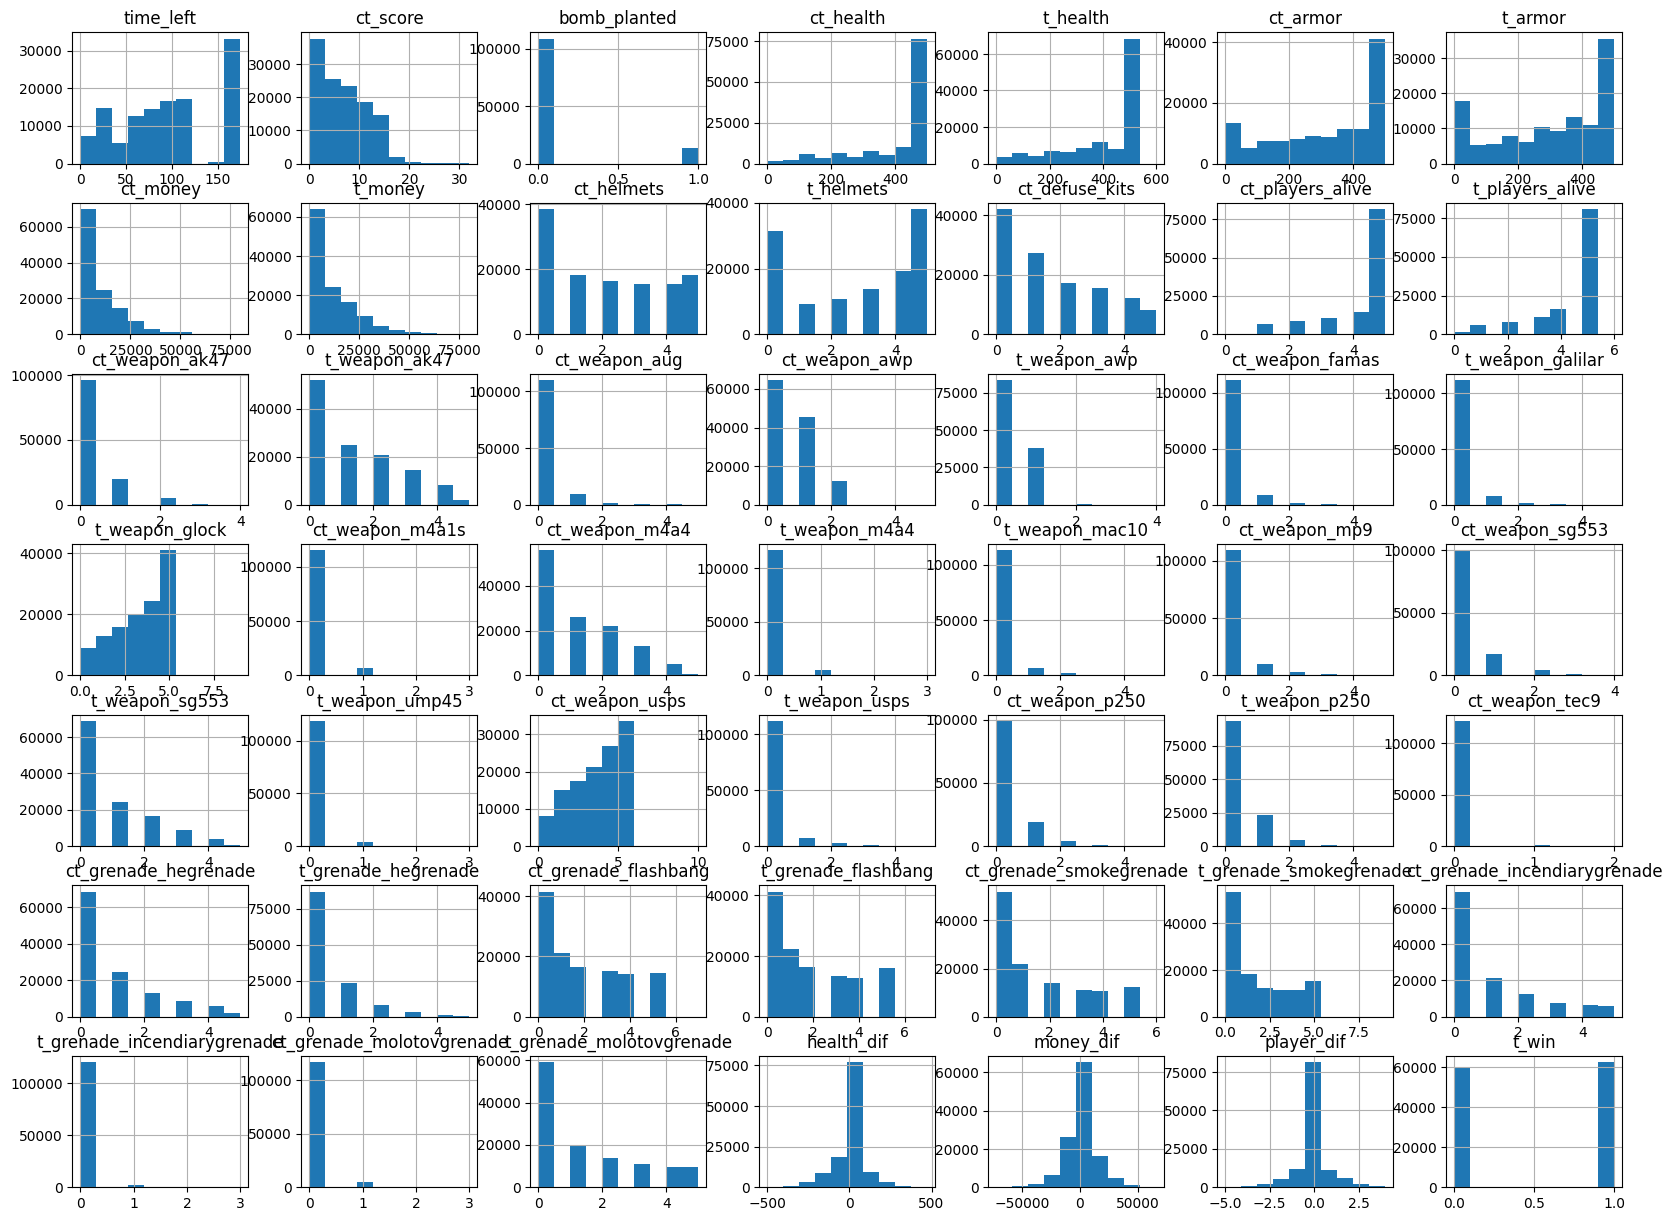

In [17]:
df_new.hist(figsize=(20,15))

In [18]:
%%time
X , y = df_new.drop(['t_win'] , axis=1) , df['t_win']

pca = PCA(n_components=1)
X['extra'] = pd.DataFrame(pca.fit_transform(df[not_selected_cols]))[0]

X_train , X_test , y_train , y_test = tts(X , y, test_size=.25)

CPU times: total: 922 ms
Wall time: 639 ms


In [19]:
X.shape

(122410, 49)

In [20]:
%%time
scaler = StandardScaler()

X_train_S = scaler.fit_transform(X_train)
X_test_S = scaler.transform(X_test)



CPU times: total: 141 ms
Wall time: 134 ms


In [21]:
X_train.shape

(91807, 49)

In [22]:
%%time
p_g = {
    'n_neighbors':list(range(5,50,5)) , 
    'weights': ['uniform' , 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':list(range(20,40 , 5)),
    'p':[1,2]
}

knn = knc(n_jobs=5)
clf = RandomizedSearchCV(knn , p_g , n_jobs=5 , n_iter=5 , verbose=2 , cv=5)
clf.fit(X_train_S , y_train)
print(clf.best_estimator_)
knn = clf.best_estimator_
knn.score(X_test_S , y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
KNeighborsClassifier(algorithm='ball_tree', n_jobs=5, p=1)
CPU times: total: 7min 27s
Wall time: 17min 10s


0.8346240564650524

In [23]:
%%time
p_g = {
    'n_estimators':list(range(100,250,10)) , 
    'max_depth': list(range(5,15,3)),
    'criterion':['gini' , 'entropy'],
    'class_weight':['balanced' , 'balanced_subsample' ]
}

f= RC(n_jobs=3)
clf = RandomizedSearchCV(f , p_g , n_jobs=3 , n_iter=10 , verbose=2 , cv=5)
clf.fit(X_train_S , y_train)
f = clf.best_estimator_
print(clf.best_estimator_)
f.score(X_test_S , y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=220,
                       n_jobs=3)
CPU times: total: 1min 4s
Wall time: 7min 21s


0.8100513021599189

In [24]:
%%time
X_t_s , X_v_s , y_t , y_v = tts(X_train_S , y_train , test_size=0.1)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(100 , activation='relu'))
model.add(keras.layers.Dense(100 , activation='relu'))
model.add(keras.layers.Dense(1 , activation='sigmoid'))

model.compile(loss='binary_crossentropy' , optimizer='adam' , metrics=['accuracy' ])
early_stop = keras.callbacks.EarlyStopping(patience=5)
model.fit(X_t_s , y_t , epochs=50 , callbacks = [early_stop] , validation_data = (X_v_s , y_v))



Epoch 1/50


2583/2583 [==============================] - 7s 2ms/step - loss: 0.4591 - accuracy: 0.7487 - val_loss: 0.4531 - val_accuracy: 0.7485
Epoch 2/50
2583/2583 [==============================] - 6s 2ms/step - loss: 0.4407 - accuracy: 0.7598 - val_loss: 0.4446 - val_accuracy: 0.7525
Epoch 3/50
2583/2583 [==============================] - 6s 2ms/step - loss: 0.4322 - accuracy: 0.7668 - val_loss: 0.4373 - val_accuracy: 0.7585
Epoch 4/50
2583/2583 [==============================] - 5s 2ms/step - loss: 0.4248 - accuracy: 0.7730 - val_loss: 0.4408 - val_accuracy: 0.7581
Epoch 5/50
2583/2583 [==============================] - 6s 2ms/step - loss: 0.4173 - accuracy: 0.7783 - val_loss: 0.4395 - val_accuracy: 0.7641
Epoch 6/50
2583/2583 [==============================] - 5s 2ms/step - loss: 0.4098 - accuracy: 0.7839 - val_loss: 0.4298 - val_accuracy: 0.7749
Epoch 7/50
2583/2583 [==============================] - 5s 2ms/step - loss: 0.4021 - accuracy: 0.7918 - val_loss: 0.4304 - val_accur

In [25]:
%%time
model.evaluate(X_test_S , y_test)

957/957 [==============================] - 1s 1ms/step - loss: 0.4306 - accuracy: 0.7870
CPU times: total: 1.73 s
Wall time: 1.52 s


[0.4306310713291168, 0.7869816422462463]

In [26]:
%%time
my_model = GradientBoostingClassifier(loss='exponential', learning_rate=0.15, n_estimators=300, max_depth=7, min_samples_split=4, min_impurity_decrease=20)
my_model.fit(X_train, y_train)
f.score(X_test_S , y_test)

CPU times: total: 59.4 s
Wall time: 58.9 s


0.8100513021599189